In [41]:
%matplotlib inline
# Computación científica
import numpy as np

# Gráficos
import matplotlib.pyplot as plt

# Mapas de colores
from matplotlib import cm

# Funciones especiales
from scipy.special import erf, erfc


#Parámetros físicos del problema
#Longitud del dominio en x [m]
Lx = 5000

#Ancho del río [m]
w = 100

#Coeficiente de decaimiento químico
ke = 1.16e-4 #[1/s]

#Coeficiente de difusión tubrulento promedio
D = 0.5 #[m^2/s]

#Velocidad en x
u0 = 0.17 #[m/s]
#Velocidad en y
v0 = 0

alpha = 1.0   # valor que quieras

# Parámetros de la profundidad [NUEVOS]
p0  = 6.0 # profundidad al inicio [m]
pf  = 4.0 # profundidad al final [m]
x0  = 0.0
xf  = Lx

h   = 0  #Posición inicial del difusor en y [m]
Wd  = 20.0   #Longitud del difusor [m]

#Condiciones iniciales (borde)
C0 = 1 #Concentración del difusor[mg/L]
CB = 0.0 #Concentración del contaminante antes del difusor



#Definimos malla
# Numero de nodos en x
Nx = 1001
# Numero de nodos en y
Ny = 41

x = np.linspace(0.0, Lx, Nx)
y = np.linspace(0.0, w,  Ny)

dx = Lx/(Nx-1)
dy = w/(Ny-1)

print("dx = %.3f, dy = %.3f m" % (dx, dy))


#Campo de velocidad [NUEVO]
X, Y = np.meshgrid(x, y, indexing='ij')

# Función de profundidad lineal
p_x = ((pf - p0)/(xf - x0))*(X - x0) + p0

# definimos un factor para simplificar al definir u
shape_y = (Y/w) * (1.0 - Y/w) * np.exp(-alpha * (Y/w))

u_raw = (p0 * shape_y) / (w * p_x)

# u0 es el máximo final
u = u0 * (u_raw / np.max(u_raw))

# Campo de velocidad transversal (aunque consideramos v0=0)
v = np.ones_like(u) * v0


# Definir valores de coeficientes constantes

# Coeficiente correspondiente a nodo vecino derecho
a = np.zeros_like(u) 

# Coeficiente correspondiente a nodo vecino izquierdo
b = -u / dx    

# Coeficiente correspondiente a nodo vecino superior
c = -D/(dy**2) 

# Coeficiente correspondiente a nodo vecino inferior
d = -(v/(dy)) - (D/dy**2)

# Coeficiente correspondiente a nodo central
e = u/dx + v/dy + 2*D/(dy**2) + ke

# Coeficiente correspondiente a término constante
f = 0

#Parámetro del método SOR
omega = 1.45
tol = 1e-6

# Algoritmo de iteración por SOR

# Inicializamos arreglo para almacenar los valores solución de la concentracion
cC = np.ones((Nx,Ny))*C0

# Aplicamos las condiciones de borde 
for j in range(Ny):
    y1 = j*dy
    if y1<= h or y1> h + Wd:
        cC[0,j]= CB
    else:
        cC[0,j]= C0


cC[:,0]= (4*cC[:,1]- cC[:,2])/ 3
cC[:,-1]= (4*cC[:,-2]- cC[:,-3])/ 3

# Inicializamos el residuo total al comienzo de iteración con un valor arbitrario
residuo_total = 1

# Inicializamos contador para numero de iteraciones  
cnt_it = 0

#Iteración [sigue el mismo formato del código anterior]
while residuo_total > tol:
    
    suma_residuos = 0.0
    nodos_actualizados = 0
    
    # Recorrer puntos internos del dominio
    for i in range(1,Nx):
        for j in range(1,Ny-1):
            
            # Calcular residuo para nodo (i,j)
            residuo_nodo = b[i,j]*cC[i-1,j] + c*cC[i,j+1] + d[i,j]*cC[i,j-1] + e[i,j]*cC[i,j] - f

            
            # Actualizar el valor de concentration
            cC[i,j] += -omega * residuo_nodo / e[i,j]
            suma_residuos += abs(residuo_nodo)
            nodos_actualizados += 1

    
    # Actualizar condiciones de borde arreglo solución de concentraciones 
    for j in range(Ny):
        y1 = j * dy
        if y1<=h or y1>h + Wd:
            cC[0,j] = CB
        else:
            cC[0,j] = C0


    cC[:,0] = (4*cC[:,1] - cC[:,2])/ 3
    cC[:,-1] = (4*cC[:,-2] - cC[:,-3])/ 3
    
    
    residuo_total = suma_residuos/ max(1, nodos_actualizados)

    if cnt_it % 100 == 0:
        print(f"Iter {cnt_it:5d}, residuo = {residuo_total:.3e}")

    cnt_it += 1


dx = 5.000, dy = 2.500 m
Iter     0, residuo = 6.045e-04
Iter   100, residuo = 3.515e-04
Iter   200, residuo = 2.214e-04
Iter   300, residuo = 1.389e-04
Iter   400, residuo = 8.681e-05
Iter   500, residuo = 5.404e-05
Iter   600, residuo = 3.348e-05
Iter   700, residuo = 2.062e-05
Iter   800, residuo = 1.261e-05
Iter   900, residuo = 7.639e-06
Iter  1000, residuo = 4.577e-06
Iter  1100, residuo = 2.703e-06
Iter  1200, residuo = 1.565e-06


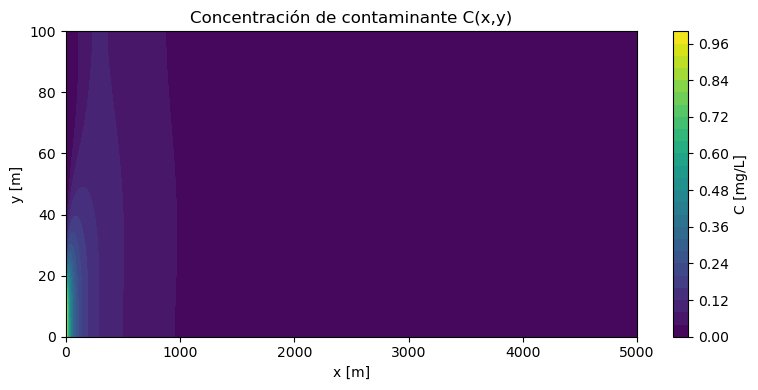

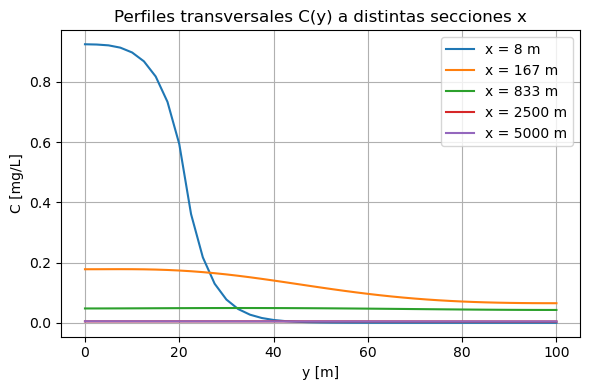

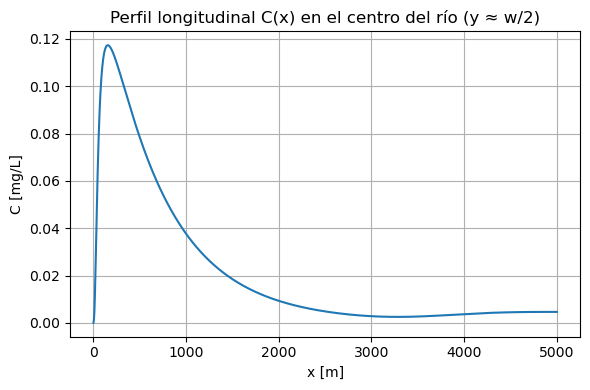

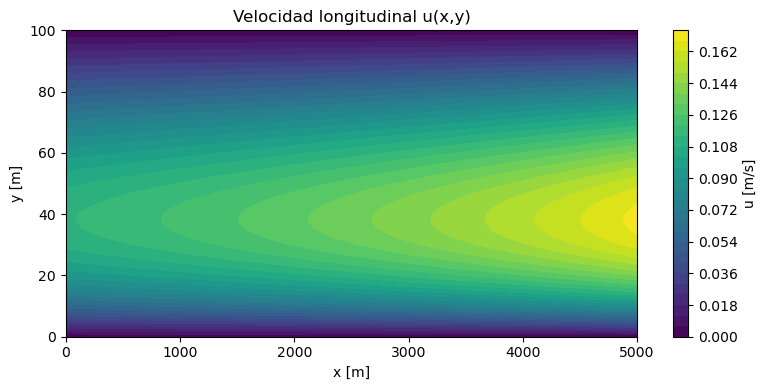

In [42]:
# GRÁFICOS
Xplot, Yplot = X, Y

# Mapa C(x,y)
plt.figure(figsize=(8,4))
cs = plt.contourf(Xplot, Yplot, cC, levels=30)
plt.colorbar(cs, label="C [mg/L]")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("Concentración de contaminante C(x,y)")
plt.tight_layout()
plt.show()

# Perfiles C(y) a distintas x
x_targets = [8, 167, 833, 2500, 5000]
idxs = [min(len(x)-1, int(xt/dx)) for xt in x_targets]

plt.figure(figsize=(6,4))
for xt, k in zip(x_targets, idxs):
    plt.plot(y, cC[k, :], label=f"x = {xt:g} m")
plt.xlabel("y [m]")
plt.ylabel("C [mg/L]")
plt.legend()
plt.grid(True)
plt.title("Perfiles transversales C(y) a distintas secciones x")
plt.tight_layout()
plt.show()

# Perfil C(x) en el centro del río
j_centro = np.argmin(np.abs(y - w/2))
plt.figure(figsize=(6,4))
plt.plot(x, cC[:, j_centro])
plt.xlabel("x [m]")
plt.ylabel("C [mg/L]")
plt.grid(True)
plt.title("Perfil longitudinal C(x) en el centro del río (y ≈ w/2)")
plt.tight_layout()
plt.show()

# Mapa u(x,y) para ver la velocidad
plt.figure(figsize=(8,4))
cs_u = plt.contourf(Xplot, Yplot, u, levels=30)
plt.colorbar(cs_u, label="u [m/s]")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("Velocidad longitudinal u(x,y)")
plt.tight_layout()
plt.show()